<a href="https://colab.research.google.com/github/cybercat17/MLDL/blob/master/Titanic_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading Datasets from Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cybercat","key":"0bdbeb40485d70cbb45bd530ae54e5dd"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 23.1MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.55MB/s]


## Exploring through Data

In [34]:
import pandas as pd

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
print('Shape : {}'.format(train_df.shape))
print('Columns : {}'.format(train_df.columns.values))
train_df.describe()

Shape : (891, 12)
Columns : ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


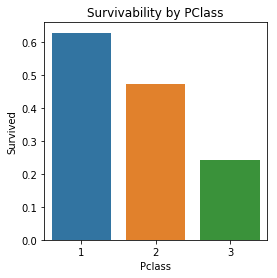

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.title("Survivability by PClass")
by_pclass = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
sns.barplot(x=by_pclass.Pclass, y=by_pclass.Survived)

Upper class passengers tended to have higher survivability.

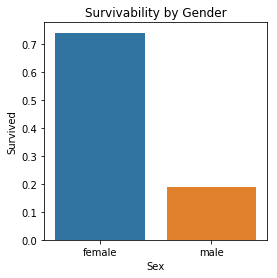

In [10]:
plt.figure(figsize=(4, 4))
plt.title("Survivability by Gender")
by_gender = train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x=by_gender.Sex, y=by_gender.Survived)

Female passengers tended to have higher survivability then male passengers.

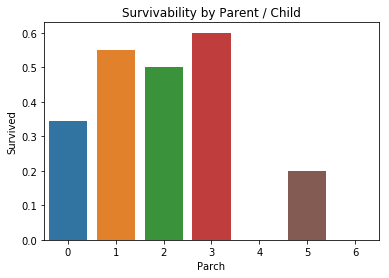

In [12]:
plt.figure(figsize=(6, 4))
plt.title("Survivability by Parent / Child")
by_parch = train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
sns.barplot(x=by_parch.Parch, y=by_parch.Survived)

Passengers with less family members tended to have higher survivability

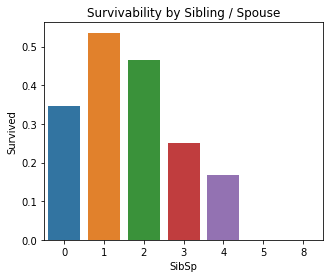

In [14]:
plt.figure(figsize=(5, 4))
plt.title("Survivability by Sibling / Spouse")
by_sibsp = train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()
sns.barplot(x=by_sibsp.SibSp, y=by_sibsp.Survived)

Passengers with less sibling or spouse tended to have higher survivability

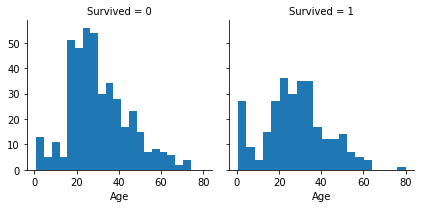

In [15]:
grid = sns.FacetGrid(train_df, col='Survived')
grid.map(plt.hist, 'Age', bins=20)

Young passengers(such as infants) tended to have higher survivability while passengers with age between 20-30 were the most deceased

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


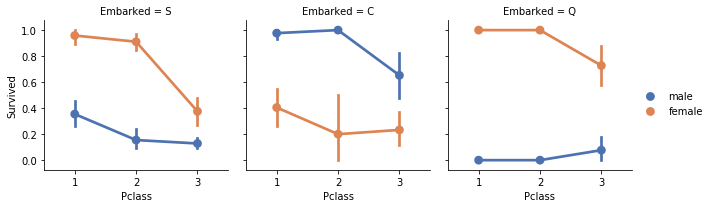

In [16]:
grid = sns.FacetGrid(train_df, col='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

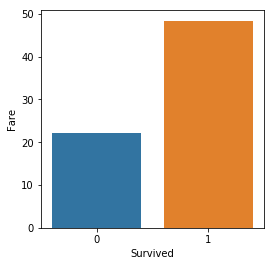

In [21]:
plt.figure(figsize=(4, 4))
by_fare = train_df[['Fare', 'Survived']].groupby(['Survived'], as_index=False).mean()
sns.barplot(x=by_fare.Survived, y=by_fare.Fare)

Passengers with higher fare tended to survive more than those with lower fare. This can also be known from the corelationship between the Pclass and the survival rate we've seen before(since higher class tended to survive).

## Dropping unrelevant columns

In [36]:
unrelevant_cols = ['PassengerId', 'Ticket', 'Cabin', 'Name']

train_df.dropna(subset=['Survived'], axis=0, inplace=True)
y = train_df.Survived
train_df.drop(labels=['Survived'], axis=1, inplace=True)

train_df.drop(labels=unrelevant_cols, axis=1, inplace=True)
test_df.drop(labels=unrelevant_cols, axis=1, inplace=True)

print('train : {} / test : {}'.format(train_df.shape, test_df.shape))

train : (891, 7) / test : (418, 7)


## Defining Pipeline

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error as MAE

In [39]:
num_cols = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']

print('Numerical columns : {}'.format(num_cols))
print('Categorical columns : {}'.format(cat_cols))

Numerical columns : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns : ['Sex', 'Embarked']


In [0]:
num_transformer = SimpleImputer(strategy='most_frequent')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

model = RandomForestClassifier(n_estimators=100, random_state=0)

ppl = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', model)
])

ppl.fit(train_df, y)
preds = ppl.predict(test_df)

output = pd.DataFrame({'PassengerId':test_df.index+892, 'Survived':preds})
output.to_csv('submission.csv', index=False)